In [92]:
import pandas as pd#importing required libararies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [93]:
df=pd.read_csv('/content/exchange_rate.csv')#loading dataset

In [94]:
df.head()#first 5 rows of dataset

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


# **Data Preparation and Exploration**

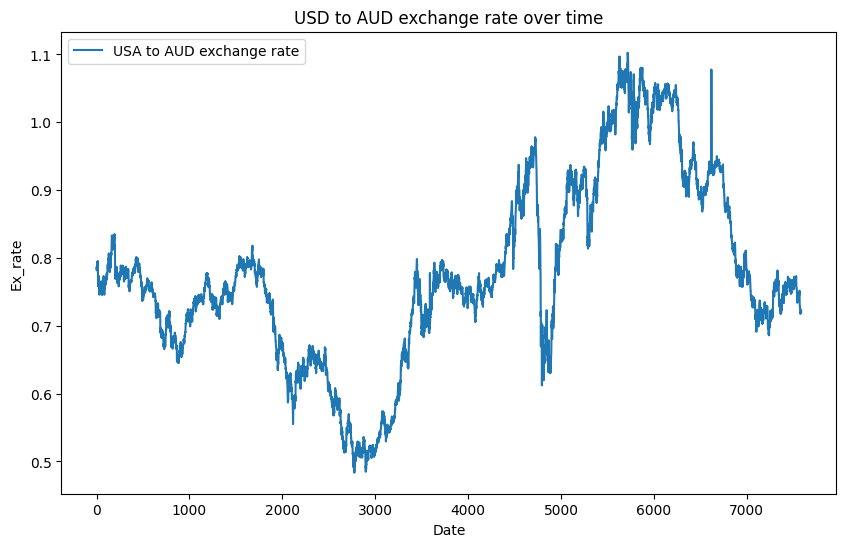

In [96]:
plt.figure(figsize=(10,6))#exploration of dataset
plt.plot(df['Ex_rate'],label='USA to AUD exchange rate')
plt.title('USD to AUD exchange rate over time')
plt.xlabel('Date')
plt.ylabel('Ex_rate')
plt.legend()

In [97]:
df.isna().sum()#checking null values

,0
date,0
Ex_rate,0


# **Model Building - ARIMA**

Text(0.5, 1.0, 'PACF Plot')

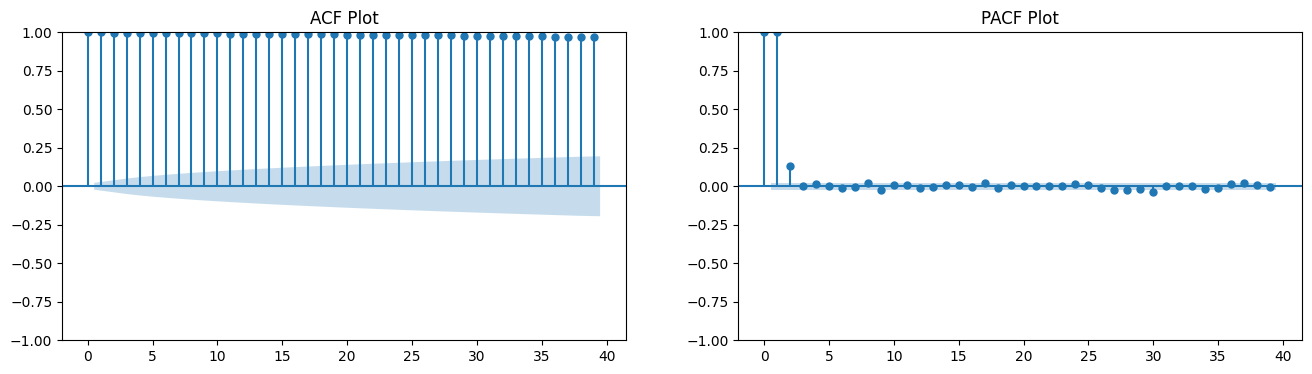

In [98]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf#ACF and  PACF plots for parameter selection

fig,axes=plt.subplots(1,2,figsize=(16,4))

plot_acf(df['Ex_rate'],ax=axes[0])
axes[0].set_title('ACF Plot')

plot_pacf(df['Ex_rate'],ax=axes[1])
axes[1].set_title('PACF Plot')

In [99]:
from statsmodels.tsa.stattools import adfuller#checking for stationarity
result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


In [100]:
#data is non_stationary because p>0.05 so taking difference of series to make stationary
df_diff = df['Ex_rate'].diff().dropna()

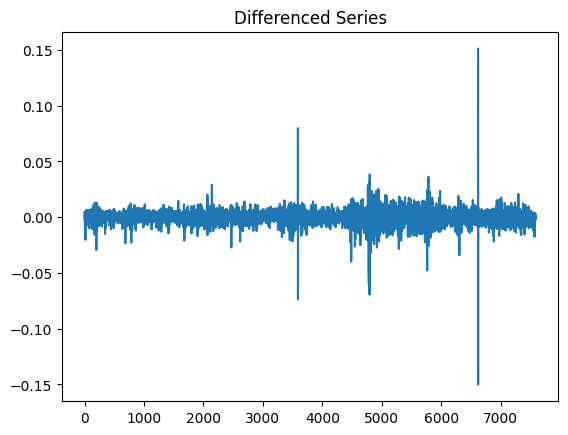

In [101]:
plt.plot(df_diff)
plt.title('Differenced Series')
plt.show()

In [102]:
from statsmodels.tsa.arima.model import ARIMA# model building

arima_model=ARIMA(df['Ex_rate'],order=(1,1,1))
arima_results=arima_model.fit()#fitting the model

arima_forecast=arima_results.forecast(steps=30)#diagnostics
actual_values=df['Ex_rate'][-30:]

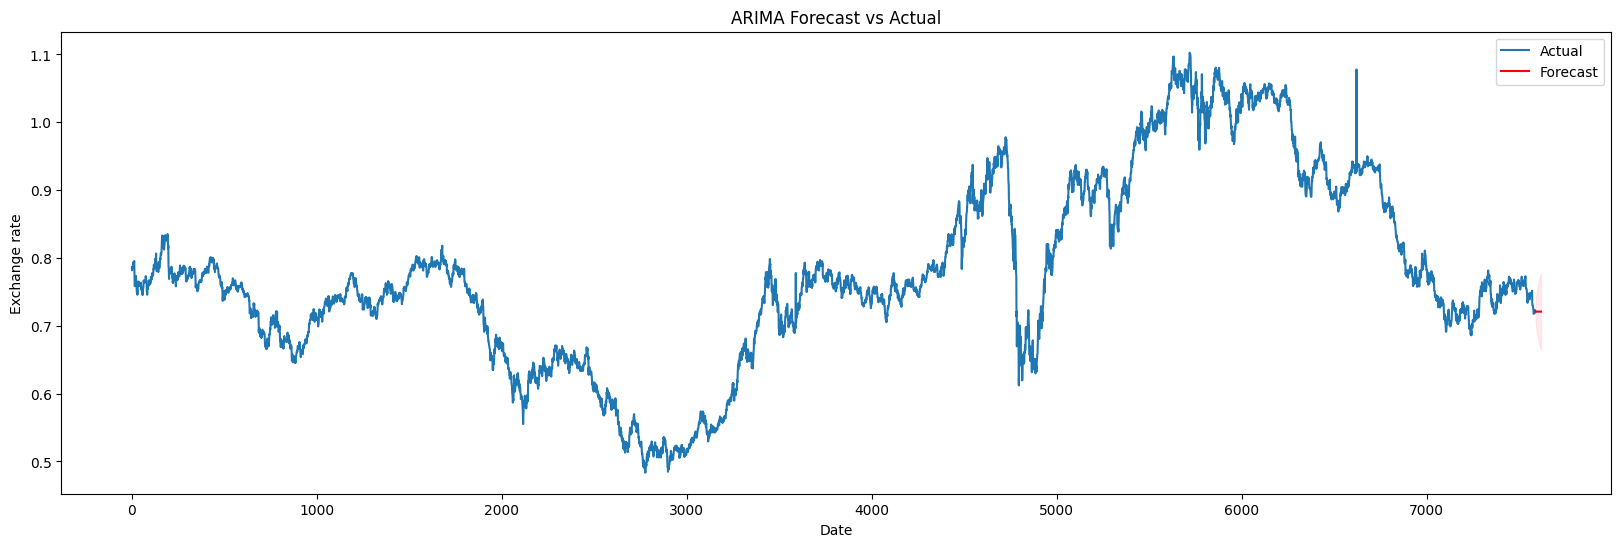

In [103]:
forecast=arima_results.get_forecast(steps=30)#forecasting 30 periods in future
forecast_values=forecast.predicted_mean
conf_int=forecast.conf_int()
#plotting actual vs forecast
plt.figure(figsize=(20,6))
plt.plot(df['Ex_rate'],label='Actual')
plt.plot(forecast_values,label='Forecast',color='red')
plt.fill_between(forecast_values.index,conf_int.iloc[:,0],conf_int.iloc[:,1],color='pink',alpha=0.3)
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.legend()

# **Model Building - Exponential Smoothing**

In [104]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Fitting Exponential Smoothing Model (Simple, Holt’s Linear, or Holt-Winters)
exp_smooth_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None, damped_trend=False).fit()



In [105]:
# Importing necessary libraries
from itertools import product

#Defining the parameter grid
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul']
seasonal_periods = [12]  # Change this based on your data's frequency (e.g., 12 for monthly data)

#Creating a list of all combinations of parameters
param_grid = product(trend_options, seasonal_options, seasonal_periods)

best_aic = float('inf')
best_params = None
best_model = None

#Iterate over all combinations of parameters
for trend, seasonal, sp in param_grid:
    try:
        model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=sp)
        fit = model.fit(optimized=True)  # Using optimization to fit the model
        aic = fit.aic  # Get AIC of the model

        if aic < best_aic:  # Compare AIC with the best AIC found so far
            best_aic = aic
            best_params = (trend, seasonal, sp)
            best_model = fit

    except Exception as e:
        print(f"Could not fit model with trend={trend}, seasonal={seasonal}, seasonal_periods={sp}: {e}")

print(f"Best AIC: {best_aic}")
print(f"Best Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Seasonal Periods={best_params[2]}")


Best AIC: -77644.98075014984
Best Parameters: Trend=None, Seasonal=None, Seasonal Periods=12


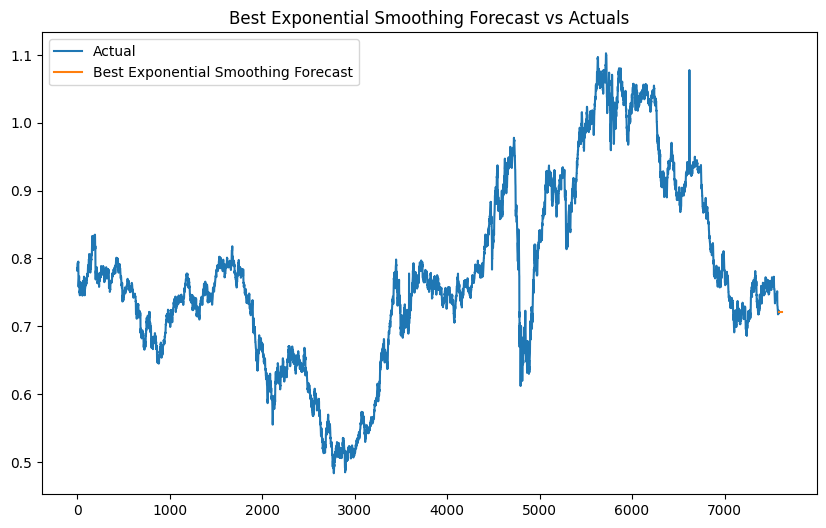

In [106]:
# Fitting the best model based on identified parameters
final_model = ExponentialSmoothing(df['Ex_rate'], trend=None, seasonal=None, seasonal_periods=12).fit()
forecast_periods=30
# Forecasting using the best model
exp_forecast_best = final_model.forecast(forecast_periods)

# Plot actual vs forecast
plt.figure(figsize=(10,6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(exp_forecast_best.index, exp_forecast_best, label='Best Exponential Smoothing Forecast')
plt.title('Best Exponential Smoothing Forecast vs Actuals')
plt.legend()
plt.show()


# **Evaluation and Comparison**

In [107]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Computing error metrics for ARIMA model

mae_arima = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast)
rmse_arima = mean_squared_error(df['Ex_rate'][-30:], arima_forecast, squared=False)

# Computing error metrics for Exponential Smoothing model
mae_es = mean_absolute_error(df['Ex_rate'][-30:], exp_forecast_best)
rmse_es = mean_squared_error(df['Ex_rate'][-30:], exp_forecast_best, squared=False)

print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'Exponential Smoothing MAE: {mae_es}, RMSE: {rmse_es}')


ARIMA MAE: 0.012724006489305202, RMSE: 0.016982710912755217
Exponential Smoothing MAE: 0.012707429455384294, RMSE: 0.016957814302365717


# **Model Comparison**

# **Advantages and Limitations**

# ARIMA:

**Advantages:**


Flexibility in modeling complex time series data through the inclusion of autoregressive (AR) and moving average (MA) components.

Capable of handling non-stationary data after appropriate differencing.

Useful for understanding underlying patterns and predicting future values based on historical data.

**Limitations:**


Requires extensive data preprocessing, including testing for stationarity and potentially transforming the data.

The model complexity can increase significantly with additional parameters, making it challenging to interpret.

Not suitable for very short time series data or when data lacks a clear pattern.

# Exponential Smoothing:

**Advantages:**


Simple and intuitive, making it easy to understand and implement.

Effective for data with trends and seasonality, especially when recent observations are more relevant.

Generally requires less preprocessing compared to ARIMA models.

**Limitations:**


Assumes that the future is a weighted average of the past, which may not hold true for all datasets.

Limited in modeling complex relationships as it primarily relies on exponential decay, which may not capture all patterns in the data.

Less effective in scenarios with significant structural changes or outliers.

# **Conclusion**

Both the ARIMA and Exponential Smoothing models yielded comparable performance in forecasting exchange rates, with both models exhibiting low MAE and RMSE values.

The slight advantage of Exponential Smoothing in terms of error metrics indicates that it may be more effective for this  dataset, especially given its simplicity and ease of implementation.


The Exponential Smoothing model may be preferred, if deeper insights into the underlying processes influencing the time series are desired, the ARIMA model may offer additional value.